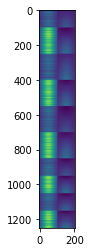

In [56]:

# Generate synthetic datasets

import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy
from scipy import signal



def gkern(kernlen=16, std=5, dim=2):
    
    """Returns a Gaussian kernel array."""
    
    kern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    if dim == 2:
        kernel_raw = numpy.outer(kern1d, kern1d)
    else:
        kernel_raw = kern1d
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def gen_feature(signal, conf, shape=(20, 20, 1), std=30):
    sig = gkern(shape[0], std, shape[2]) * signal * shape[0]
    conf = gkern(shape[1], std, shape[2]) * conf * shape[1]
    feat = np.concatenate((sig, conf))
    if shape[1] == 1:
        return feat.flatten()
    else:
        return feat

SIZE_SIGNAL = 100
SIZE_CONF = 100
# cm = sns.light_palette("green", as_cmap=True)
dfs = []
for batch_id in range(5):
    
    n_class_0 = np.random.choice([100, 150])
    n_class_1 = np.random.choice([100, 150])

    min_conf_class_0 = np.random.choice([0, -1])
    max_conf_class_0 = np.random.choice([2, 3])

    min_conf_class_1 = np.random.choice([-1])
    max_conf_class_1 = np.random.choice([3])

    df_conf = pd.DataFrame(zip(
        np.concatenate((
            np.zeros(n_class_0),
            np.ones(n_class_1),)
            ),
        np.concatenate((
            np.random.uniform(min_conf_class_0, max_conf_class_0, size=n_class_0),
            np.random.uniform(min_conf_class_1, max_conf_class_1, size=n_class_1))
            ),
        np.concatenate((
            np.random.uniform(1, 4, size=n_class_0),
            np.random.uniform(5, 10, size=n_class_1))
            ),
    ), 
    columns=['label', 'confounder','signal'])
    df_conf['batch_id'] = batch_id
    df_conf['feature'] = df_conf.apply(lambda x: gen_feature(x['signal'], x['confounder'], shape=(SIZE_SIGNAL, SIZE_CONF, 1)), axis=1)
    df_conf = df_conf.explode("feature")
    df_conf['feat_name'] = list(range(SIZE_SIGNAL+SIZE_CONF)) * (n_class_0 + n_class_1)

    df_conf = df_conf.pivot(index=['label','confounder','signal','batch_id'], columns='feat_name', values='feature').reset_index().astype(float)

    df_conf.columns.name = None
    
    dfs.append(df_conf)

df_conf = pd.concat(dfs)
df_conf['batch_id'] = df_conf['batch_id'].astype(int)
df_conf['label'] = df_conf['label'].astype(int)
plt.imshow(df_conf.values)

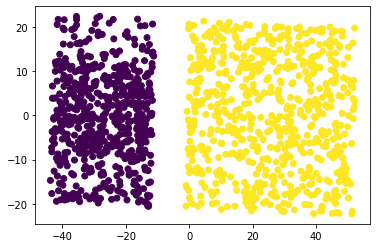

In [60]:
from sklearn.decomposition import PCA

pca = PCA()

conf_pca = pca.fit_transform(df_conf.iloc[:, 4:])
plt.scatter(x=conf_pca[:, 0], y=conf_pca[:, 1], c=df_conf['label'])


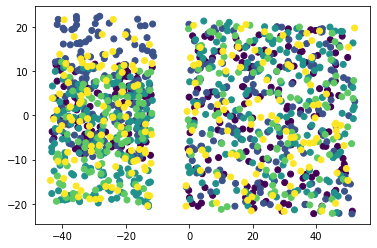

In [61]:
plt.scatter(x=conf_pca[:, 0], y=conf_pca[:, 1], c=df_conf['batch_id'])